In [2]:
from droplet_growth import multiwell
from functools import partial
from glob import glob
from tifffile import imread
from nd2_combine import tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pims_nd2 as nd
from skimage.filters import threshold_otsu
from skimage.measure import regionprops
import seaborn as sns
from segment import seg

import logging

# logging.basicConfig(level=logging.DEBUG)
log = logging.getLogger(__name__)
log.setLevel('DEBUG')

In [3]:
def segment_bf(well, thr=0.3, smooth=10, erode=10, fill=True, plot=False, verbose=0):
    '''
    Serments input 2d array using thresholded gradient with filling
    
    1. get gradient
    2. smooth with sigma
    3. threshold according to max * thr
    4. fill holes
    5. erode
    
    Returns labels
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    if verbose:
        print(f'{n_labels} regions')
    if plot:
        fig, ax = multiwell.plt.subplots(1,2)
        ax[0].imshow(well, cmap='gray')
        ax[1].imshow(labels)
        plt.show()
        
    return labels

In [4]:
def crop_bbox(img, bbox):
    y1, x1, y2, x2 = bbox
    crop = img[y1:y2, x1:x2]
    return crop

In [5]:
def get_largest_feature(labels, intensity_image=None, plot=True):
    props = multiwell.regionprops(
        labels, 
        intensity_image=intensity_image)
    biggest_prop = props[np.argmax([p.area for p in props])]
    area = biggest_prop.area
    log.debug(f'total area = {area}')
    
    staining = crop_bbox(intensity_image, biggest_prop.bbox)
    thr = threshold_otsu(staining)
    mask = staining > thr
    staining_area = mask.sum()
    log.debug(f'staining area = {staining_area}')
    
    ratio = float(staining_area) / float(area)
    log.debug(f'ratio {ratio:.0%}')
    
    if plot:
        fig, ax = plt.subplots(1, 2)
        
        ax[0].imshow(staining)
        ax[0].set_title(f'area = {area}')
        ax[1].imshow(mask)
        ax[1].set_title(f'area = {staining_area}')
        plt.show()
    return ratio

In [6]:
paths = glob('/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/*.tif')

In [7]:
reader = imread(paths[0])

In [8]:
reader.shape

(2, 2044, 2048)

In [9]:
calibration = 1.625 #um per px

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/5.tif


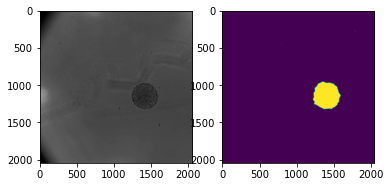

DEBUG:__main__:total area = 103680
DEBUG:__main__:staining area = 23077
DEBUG:__main__:ratio 22%


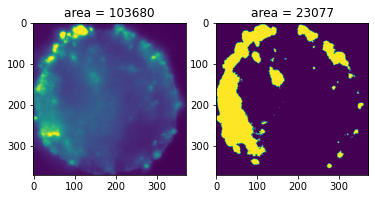

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/1.tif


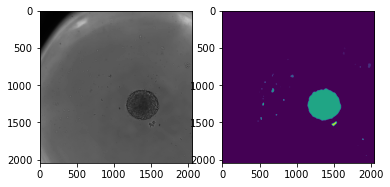

DEBUG:__main__:total area = 142262
DEBUG:__main__:staining area = 5756
DEBUG:__main__:ratio 4%


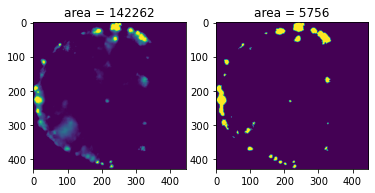

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/9.tif


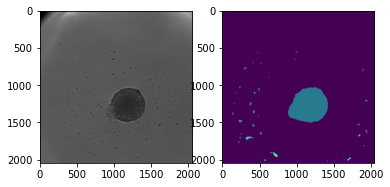

DEBUG:__main__:total area = 189079
DEBUG:__main__:staining area = 139845
DEBUG:__main__:ratio 74%


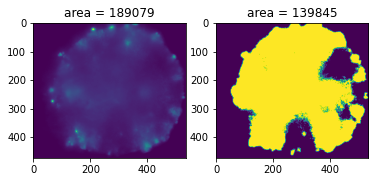

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/2.tif


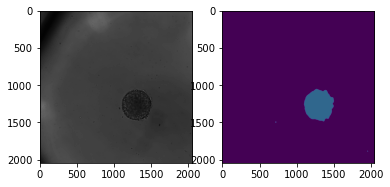

DEBUG:__main__:total area = 129316
DEBUG:__main__:staining area = 14115
DEBUG:__main__:ratio 11%


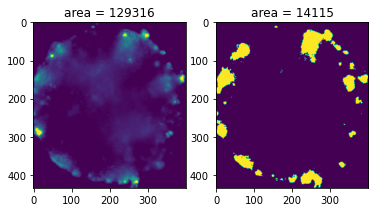

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/4.tif


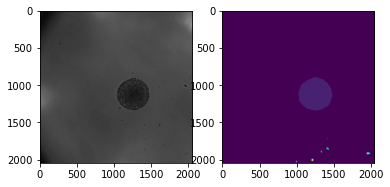

DEBUG:__main__:total area = 155521
DEBUG:__main__:staining area = 63559
DEBUG:__main__:ratio 41%


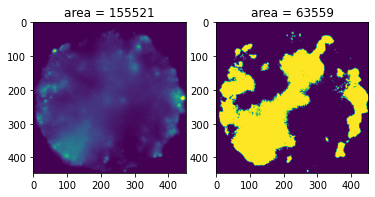

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/7.tif


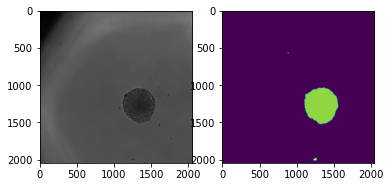

DEBUG:__main__:total area = 168532
DEBUG:__main__:staining area = 20452
DEBUG:__main__:ratio 12%


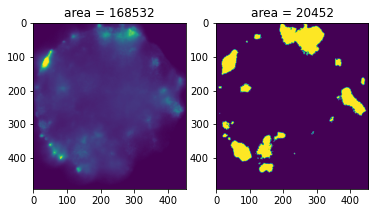

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/8.tif


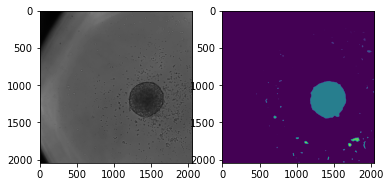

DEBUG:__main__:total area = 184703
DEBUG:__main__:staining area = 115488
DEBUG:__main__:ratio 63%


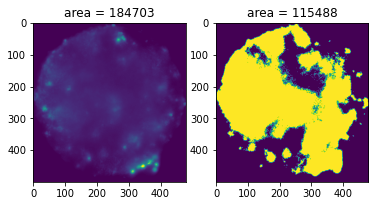

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/11.tif


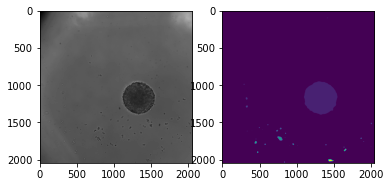

DEBUG:__main__:total area = 151628
DEBUG:__main__:staining area = 80902
DEBUG:__main__:ratio 53%


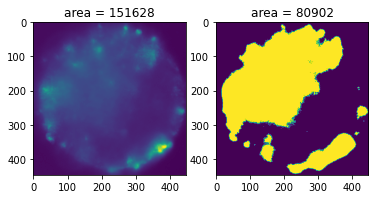

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/12.tif


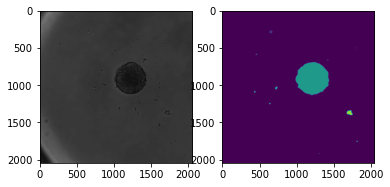

DEBUG:__main__:total area = 147936
DEBUG:__main__:staining area = 26837
DEBUG:__main__:ratio 18%


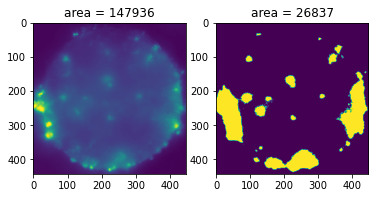

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/3.tif


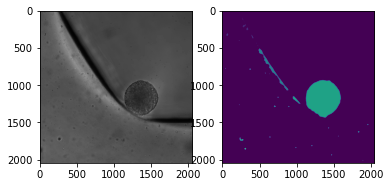

DEBUG:__main__:total area = 172890
DEBUG:__main__:staining area = 2817
DEBUG:__main__:ratio 2%


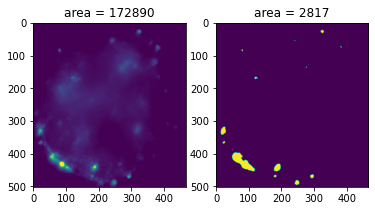

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/6.tif


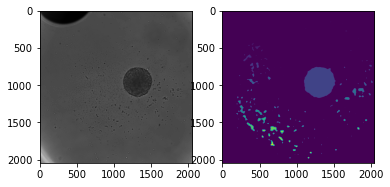

DEBUG:__main__:total area = 133160
DEBUG:__main__:staining area = 107618
DEBUG:__main__:ratio 81%


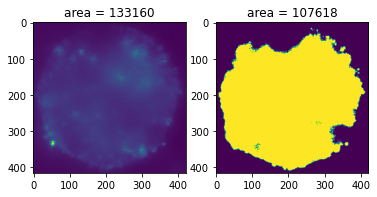

INFO:__main__:/home/aaristov/Multicell/Sebastien/mESC_aggregates/Viability_D4_Undiff/10.tif


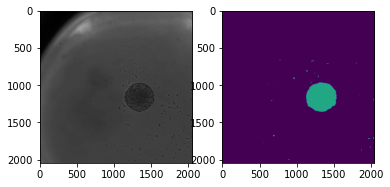

DEBUG:__main__:total area = 124939
DEBUG:__main__:staining area = 91103
DEBUG:__main__:ratio 73%


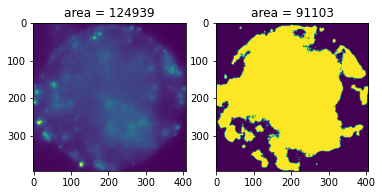

[0.22257908950617283, 0.04046055868749209, 0.7396114851464203, 0.10915122645302978, 0.40868435773946926, 0.12135380817886217, 0.6252632604776317, 0.5335558076344739, 0.18140952844473285, 0.01629359708485164, 0.8081856413337338, 0.7291798397618038]


In [10]:
def analyse_viability(path):
    log.info(path)
    stack3D = imread(path)
    lb = segment_bf(stack3D[1], plot=1)
    ratio = get_largest_feature(lb, stack3D[0])
    return ratio
    
ratios = list(map(analyse_viability, paths))
print(ratios)

(array([2., 2., 2., 0., 1., 0., 1., 1., 0., 3.]),
 array([0.0162936 , 0.0954828 , 0.17467201, 0.25386121, 0.33305041,
        0.41223962, 0.49142882, 0.57061803, 0.64980723, 0.72899644,
        0.80818564]),
 <a list of 10 Patch objects>)

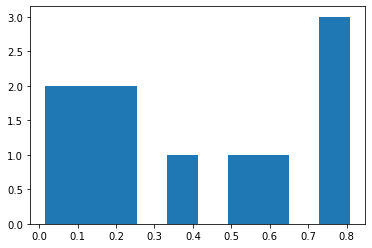

In [11]:
plt.hist(ratios)

In [12]:
np.mean(ratios)

0.37797735003738947